# Lightgbm

In [1]:
import numpy as np
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

import lightgbm

from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler

from IPython.display import display

from utils import *

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load data

In [3]:
train = pd.read_csv('input/train.csv')
print(train.shape)

(307511, 199)


In [4]:
#display(train.head(2))

In [5]:
test = pd.read_csv('input/test.csv')
print(test.shape)

(48744, 198)


### Load possible outliers (Optional)

In [3]:
outliers_idx = np.load('isolation_forest_outliers.npy', mmap_mode='r')
outliers_idx = np.array(outliers_idx)

Outliers removal (optional step)

In [ ]:
train = train.drop(index=train.index[outliers_idx])
train = train.reset_index(drop=True)

Removing service and target columns

In [6]:
targets = train[['TARGET']]

train_ids = train['SK_ID_CURR']
train = train.drop(columns=['SK_ID_CURR', 'TARGET'])

In [7]:
test_ids = test['SK_ID_CURR']
test = test.drop(columns=['SK_ID_CURR'])

In [8]:
targets.shape

(307511, 1)

### Drop redundant columns
Columns which almost identical (correlation is close to 1)

In [9]:
cols_drop = appartment_mode_cols + appartment_medi_cols
train.drop(columns=cols_drop, inplace=True)
test.drop(columns=cols_drop, inplace=True)

In [10]:
print(train.shape)
print(test.shape)

(307511, 177)
(48744, 177)


### List Categorical Features

In [11]:
cat_features = train.select_dtypes('object').columns.tolist()

In [12]:
for col in cat_features: 
    train[col] = train[col].astype('category') 
    test[col] = test[col].astype('category') 

### Parameter Tuning

In [13]:
best_params = {
    'learning_rate': 0.1,
    'max_depth': -1,
    'min_child_samples': 20,
    'n_estimators': 10000,
    'num_leaves': 32,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5
}

params = {
    'learning_rate': [0.01, 0.001],
    'n_estimators': [16000, 32000],
    'num_leaves': [32, 64],
    'max_depth': [-1, 7],
    'min_child_samples': [40, 80],
    'reg_alpha': [1.0, 2.0],
    'reg_lambda': [0.5, 1.0],
    'max_bin': [255]
}

# rscv = RandomizedSearchCV(model, params, n_iter=20, cv=5, n_jobs=1, verbose=1)
# rscv.fit(train, targets[['TARGET']], categorical_feature=cat_features,
#          eval_metric='auc', verbose=100)
cv_results = []

for i, param_smple in enumerate(list(ParameterSampler(params, 20))):
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    valid_scores = []
    train_scores = []
    params_ = dict(param_smple)
    params_['params'] = param_smple
    start = time.time()
    fold_i = 0
    for train_indices, valid_indices in k_fold.split(train, targets):
        train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
        valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
        test_features = test
        model = lightgbm.LGBMClassifier(n_estimators=param_smple['n_estimators'], objective='binary', 
                                    class_weight='balanced', learning_rate=param_smple['learning_rate'], 
                                    num_leaves=param_smple['num_leaves'], max_depth=param_smple['max_depth'],
                                    reg_alpha=param_smple['reg_alpha'], reg_lambda=param_smple['reg_lambda'], 
                                    min_child_samples=param_smple['min_child_samples'],
                                    subsample=0.8, n_jobs=6, random_state=4242, max_bin=param_smple['max_bin'])
    
        model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                      eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                      eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

        valid_scores.append(model.best_score_['valid']['auc'])
        train_scores.append(model.best_score_['train']['auc'])
        params_['train_score_%s' % fold_i] = model.best_score_['train']['auc']
        params_['valid_score_%s' % fold_i] = model.best_score_['valid']['auc']
        fold_i += 1
    
    end = time.time()
    params_['fit_time'] = end - start
    params_['mean_train_score'] = np.mean(train_scores)
    params_['mean_valid_score'] = np.mean(valid_scores)
    cv_results.append(params_)
    

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.744043	valid's auc: 0.721205
[200]	train's auc: 0.749412	valid's auc: 0.726256
[300]	train's auc: 0.752912	valid's auc: 0.729397
[400]	train's auc: 0.755533	valid's auc: 0.731332
[500]	train's auc: 0.757718	valid's auc: 0.732771
[600]	train's auc: 0.759634	valid's auc: 0.734054
[700]	train's auc: 0.761754	valid's auc: 0.735551
[800]	train's auc: 0.76361	valid's auc: 0.736733
[900]	train's auc: 0.765608	valid's auc: 0.73811
[1000]	train's auc: 0.767599	valid's auc: 0.739407
[1100]	train's auc: 0.769686	valid's auc: 0.74086
[1200]	train's auc: 0.77179	valid's auc: 0.742156
[1300]	train's auc: 0.774107	valid's auc: 0.743576
[1400]	train's auc: 0.776304	valid's auc: 0.744865
[1500]	train's auc: 0.778421	valid's auc: 0.746115
[1600]	train's auc: 0.780451	valid's auc: 0.747308
[1700]	train's auc: 0.782495	valid's auc: 0.748458
[1800]	train's auc: 0.784494	valid's auc: 0.749499
[1900]	train's auc: 0.786653	val

[2600]	train's auc: 0.799716	valid's auc: 0.76158
[2700]	train's auc: 0.801304	valid's auc: 0.762308
[2800]	train's auc: 0.802864	valid's auc: 0.763002
[2900]	train's auc: 0.804421	valid's auc: 0.763683
[3000]	train's auc: 0.805896	valid's auc: 0.764259
[3100]	train's auc: 0.807374	valid's auc: 0.764853
[3200]	train's auc: 0.808805	valid's auc: 0.765428
[3300]	train's auc: 0.810191	valid's auc: 0.765946
[3400]	train's auc: 0.811518	valid's auc: 0.766428
[3500]	train's auc: 0.812797	valid's auc: 0.766842
[3600]	train's auc: 0.814099	valid's auc: 0.767309
[3700]	train's auc: 0.815364	valid's auc: 0.76771
[3800]	train's auc: 0.81658	valid's auc: 0.768098
[3900]	train's auc: 0.817796	valid's auc: 0.768499
[4000]	train's auc: 0.819001	valid's auc: 0.768913
[4100]	train's auc: 0.820172	valid's auc: 0.769342
[4200]	train's auc: 0.821319	valid's auc: 0.769714
[4300]	train's auc: 0.822442	valid's auc: 0.770079
[4400]	train's auc: 0.823545	valid's auc: 0.770425
[4500]	train's auc: 0.824665	valid

[7200]	train's auc: 0.850364	valid's auc: 0.77595
[7300]	train's auc: 0.851205	valid's auc: 0.776032
[7400]	train's auc: 0.852047	valid's auc: 0.776137
[7500]	train's auc: 0.852886	valid's auc: 0.776227
[7600]	train's auc: 0.853699	valid's auc: 0.776295
[7700]	train's auc: 0.854518	valid's auc: 0.776374
[7800]	train's auc: 0.855322	valid's auc: 0.776456
[7900]	train's auc: 0.856114	valid's auc: 0.776523
[8000]	train's auc: 0.856887	valid's auc: 0.776587
[8100]	train's auc: 0.857659	valid's auc: 0.776637
[8200]	train's auc: 0.85842	valid's auc: 0.77668
[8300]	train's auc: 0.85917	valid's auc: 0.776719
[8400]	train's auc: 0.859904	valid's auc: 0.776748
[8500]	train's auc: 0.860636	valid's auc: 0.776765
[8600]	train's auc: 0.86135	valid's auc: 0.776799
[8700]	train's auc: 0.862058	valid's auc: 0.776827
[8800]	train's auc: 0.862758	valid's auc: 0.776853
[8900]	train's auc: 0.863457	valid's auc: 0.776872
[9000]	train's auc: 0.864162	valid's auc: 0.776899
[9100]	train's auc: 0.864865	valid's

[2000]	train's auc: 0.787876	valid's auc: 0.755709
[2100]	train's auc: 0.789929	valid's auc: 0.756918
[2200]	train's auc: 0.791856	valid's auc: 0.757947
[2300]	train's auc: 0.793788	valid's auc: 0.758963
[2400]	train's auc: 0.795675	valid's auc: 0.759899
[2500]	train's auc: 0.797455	valid's auc: 0.760789
[2600]	train's auc: 0.799102	valid's auc: 0.761557
[2700]	train's auc: 0.800735	valid's auc: 0.762316
[2800]	train's auc: 0.80235	valid's auc: 0.763026
[2900]	train's auc: 0.803918	valid's auc: 0.763668
[3000]	train's auc: 0.805423	valid's auc: 0.7643
[3100]	train's auc: 0.806922	valid's auc: 0.764934
[3200]	train's auc: 0.808358	valid's auc: 0.765493
[3300]	train's auc: 0.809767	valid's auc: 0.76606
[3400]	train's auc: 0.811153	valid's auc: 0.766549
[3500]	train's auc: 0.812466	valid's auc: 0.767022
[3600]	train's auc: 0.813772	valid's auc: 0.767483
[3700]	train's auc: 0.81505	valid's auc: 0.767919
[3800]	train's auc: 0.816314	valid's auc: 0.768352
[3900]	train's auc: 0.817589	valid's

[7200]	train's auc: 0.842973	valid's auc: 0.770529
[7300]	train's auc: 0.843655	valid's auc: 0.770642
[7400]	train's auc: 0.844331	valid's auc: 0.770762
[7500]	train's auc: 0.845023	valid's auc: 0.770892
[7600]	train's auc: 0.845718	valid's auc: 0.771009
[7700]	train's auc: 0.846357	valid's auc: 0.771113
[7800]	train's auc: 0.846988	valid's auc: 0.771209
[7900]	train's auc: 0.847632	valid's auc: 0.771304
[8000]	train's auc: 0.848273	valid's auc: 0.771401
[8100]	train's auc: 0.848892	valid's auc: 0.771495
[8200]	train's auc: 0.849493	valid's auc: 0.771576
[8300]	train's auc: 0.850089	valid's auc: 0.771655
[8400]	train's auc: 0.850693	valid's auc: 0.77172
[8500]	train's auc: 0.851285	valid's auc: 0.771781
[8600]	train's auc: 0.851885	valid's auc: 0.771858
[8700]	train's auc: 0.852468	valid's auc: 0.771925
[8800]	train's auc: 0.853056	valid's auc: 0.771998
[8900]	train's auc: 0.853628	valid's auc: 0.772065
[9000]	train's auc: 0.854206	valid's auc: 0.77215
[9100]	train's auc: 0.854766	vali

[9600]	train's auc: 0.855401	valid's auc: 0.775762
[9700]	train's auc: 0.855923	valid's auc: 0.775797
[9800]	train's auc: 0.856444	valid's auc: 0.775846
[9900]	train's auc: 0.856951	valid's auc: 0.775885
[10000]	train's auc: 0.857431	valid's auc: 0.775918
[10100]	train's auc: 0.857929	valid's auc: 0.775945
[10200]	train's auc: 0.858422	valid's auc: 0.775969
[10300]	train's auc: 0.858928	valid's auc: 0.776006
[10400]	train's auc: 0.859435	valid's auc: 0.776046
[10500]	train's auc: 0.859956	valid's auc: 0.776087
[10600]	train's auc: 0.860472	valid's auc: 0.776124
[10700]	train's auc: 0.860988	valid's auc: 0.776156
[10800]	train's auc: 0.861503	valid's auc: 0.776182
[10900]	train's auc: 0.862	valid's auc: 0.776201
[11000]	train's auc: 0.862496	valid's auc: 0.776237
[11100]	train's auc: 0.862985	valid's auc: 0.776276
[11200]	train's auc: 0.863448	valid's auc: 0.776334
[11300]	train's auc: 0.863908	valid's auc: 0.776383
[11400]	train's auc: 0.864352	valid's auc: 0.776436
[11500]	train's auc

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.741999	valid's auc: 0.725425
[200]	train's auc: 0.747472	valid's auc: 0.730653
[300]	train's auc: 0.750837	valid's auc: 0.732941
[400]	train's auc: 0.752938	valid's auc: 0.734546
[500]	train's auc: 0.755102	valid's auc: 0.736219
[600]	train's auc: 0.757098	valid's auc: 0.737533
[700]	train's auc: 0.759092	valid's auc: 0.738911
[800]	train's auc: 0.760979	valid's auc: 0.740019
[900]	train's auc: 0.762927	valid's auc: 0.7411
[1000]	train's auc: 0.764785	valid's auc: 0.742118
[1100]	train's auc: 0.766729	valid's auc: 0.743248
[1200]	train's auc: 0.768785	valid's auc: 0.744352
[1300]	train's auc: 0.770859	valid's auc: 0.745386
[1400]	train's auc: 0.772947	valid's auc: 0.746515
[1500]	train's auc: 0.774992	valid's auc: 0.747642
[1600]	train's auc: 0.776981	valid's auc: 0.748725
[1700]	train's auc: 0.778962	valid's auc: 0.749891
[1800]	train's auc: 0.780947	valid's auc: 0.751141
[1900]	train's auc: 0.783069	v

[3100]	train's auc: 0.803325	valid's auc: 0.76242
[3200]	train's auc: 0.804708	valid's auc: 0.762992
[3300]	train's auc: 0.80605	valid's auc: 0.763516
[3400]	train's auc: 0.807361	valid's auc: 0.764011
[3500]	train's auc: 0.808628	valid's auc: 0.764491
[3600]	train's auc: 0.809842	valid's auc: 0.764911
[3700]	train's auc: 0.811065	valid's auc: 0.765332
[3800]	train's auc: 0.812296	valid's auc: 0.765785
[3900]	train's auc: 0.813491	valid's auc: 0.766188
[4000]	train's auc: 0.814581	valid's auc: 0.766564
[4100]	train's auc: 0.815668	valid's auc: 0.76692
[4200]	train's auc: 0.816732	valid's auc: 0.7673
[4300]	train's auc: 0.817772	valid's auc: 0.767667
[4400]	train's auc: 0.818777	valid's auc: 0.768007
[4500]	train's auc: 0.81975	valid's auc: 0.768297
[4600]	train's auc: 0.820697	valid's auc: 0.768561
[4700]	train's auc: 0.821618	valid's auc: 0.768812
[4800]	train's auc: 0.822521	valid's auc: 0.769048
[4900]	train's auc: 0.82341	valid's auc: 0.769268
[5000]	train's auc: 0.824291	valid's a

[1300]	train's auc: 0.875728	valid's auc: 0.774057
[1400]	train's auc: 0.880535	valid's auc: 0.774113
Early stopping, best iteration is:
[1359]	train's auc: 0.878551	valid's auc: 0.774137
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.76384	valid's auc: 0.741542
[200]	train's auc: 0.784879	valid's auc: 0.753867
[300]	train's auc: 0.802005	valid's auc: 0.762223
[400]	train's auc: 0.814642	valid's auc: 0.766839
[500]	train's auc: 0.82447	valid's auc: 0.769637
[600]	train's auc: 0.832878	valid's auc: 0.771513
[700]	train's auc: 0.840464	valid's auc: 0.772673
[800]	train's auc: 0.847266	valid's auc: 0.773486
[900]	train's auc: 0.85359	valid's auc: 0.773936
[1000]	train's auc: 0.859436	valid's auc: 0.774316
[1100]	train's auc: 0.864915	valid's auc: 0.774534
[1200]	train's auc: 0.869834	valid's auc: 0.774663
[1300]	train's auc: 0.874622	valid's auc: 0.774664
Early stopping, best iteration is:
[1282]	train's auc: 0.873779	valid's auc: 0.774715
Training unt

[2100]	train's auc: 0.787775	valid's auc: 0.754771
[2200]	train's auc: 0.789704	valid's auc: 0.755918
[2300]	train's auc: 0.791522	valid's auc: 0.756969
[2400]	train's auc: 0.79324	valid's auc: 0.757948
[2500]	train's auc: 0.794941	valid's auc: 0.758811
[2600]	train's auc: 0.796603	valid's auc: 0.759605
[2700]	train's auc: 0.798178	valid's auc: 0.760311
[2800]	train's auc: 0.799693	valid's auc: 0.761025
[2900]	train's auc: 0.801143	valid's auc: 0.761629
[3000]	train's auc: 0.802582	valid's auc: 0.762219
[3100]	train's auc: 0.804004	valid's auc: 0.762825
[3200]	train's auc: 0.805356	valid's auc: 0.763405
[3300]	train's auc: 0.806681	valid's auc: 0.763968
[3400]	train's auc: 0.807962	valid's auc: 0.76451
[3500]	train's auc: 0.80918	valid's auc: 0.765004
[3600]	train's auc: 0.810397	valid's auc: 0.765462
[3700]	train's auc: 0.811577	valid's auc: 0.765908
[3800]	train's auc: 0.81273	valid's auc: 0.766339
[3900]	train's auc: 0.813861	valid's auc: 0.766764
[4000]	train's auc: 0.814973	valid'

[4200]	train's auc: 0.816562	valid's auc: 0.768574
[4300]	train's auc: 0.817591	valid's auc: 0.76892
[4400]	train's auc: 0.818624	valid's auc: 0.769262
[4500]	train's auc: 0.819648	valid's auc: 0.769602
[4600]	train's auc: 0.820606	valid's auc: 0.769885
[4700]	train's auc: 0.821563	valid's auc: 0.770159
[4800]	train's auc: 0.822499	valid's auc: 0.77044
[4900]	train's auc: 0.823449	valid's auc: 0.770707
[5000]	train's auc: 0.824351	valid's auc: 0.770933
[5100]	train's auc: 0.825268	valid's auc: 0.771158
[5200]	train's auc: 0.82618	valid's auc: 0.771391
[5300]	train's auc: 0.827092	valid's auc: 0.771619
[5400]	train's auc: 0.827975	valid's auc: 0.771824
[5500]	train's auc: 0.828858	valid's auc: 0.772039
[5600]	train's auc: 0.829715	valid's auc: 0.772235
[5700]	train's auc: 0.830561	valid's auc: 0.772411
[5800]	train's auc: 0.831401	valid's auc: 0.772578
[5900]	train's auc: 0.832222	valid's auc: 0.772725
[6000]	train's auc: 0.833005	valid's auc: 0.772865
[6100]	train's auc: 0.833772	valid

[7100]	train's auc: 0.840917	valid's auc: 0.771722
[7200]	train's auc: 0.841572	valid's auc: 0.771807
[7300]	train's auc: 0.842229	valid's auc: 0.7719
[7400]	train's auc: 0.842886	valid's auc: 0.771972
[7500]	train's auc: 0.843527	valid's auc: 0.772054
[7600]	train's auc: 0.844184	valid's auc: 0.772166
[7700]	train's auc: 0.844833	valid's auc: 0.77227
[7800]	train's auc: 0.845472	valid's auc: 0.772352
[7900]	train's auc: 0.846092	valid's auc: 0.772426
[8000]	train's auc: 0.846703	valid's auc: 0.772488
[8100]	train's auc: 0.84731	valid's auc: 0.772553
[8200]	train's auc: 0.847923	valid's auc: 0.772624
[8300]	train's auc: 0.848554	valid's auc: 0.772683
[8400]	train's auc: 0.849198	valid's auc: 0.772728
[8500]	train's auc: 0.849818	valid's auc: 0.77278
[8600]	train's auc: 0.850452	valid's auc: 0.772848
[8700]	train's auc: 0.851083	valid's auc: 0.772913
[8800]	train's auc: 0.851712	valid's auc: 0.772975
[8900]	train's auc: 0.85232	valid's auc: 0.773036
[9000]	train's auc: 0.852908	valid's 

[11000]	train's auc: 0.863701	valid's auc: 0.774373
[11100]	train's auc: 0.864201	valid's auc: 0.774383
[11200]	train's auc: 0.864709	valid's auc: 0.774394
[11300]	train's auc: 0.865232	valid's auc: 0.774402
[11400]	train's auc: 0.865752	valid's auc: 0.774414
[11500]	train's auc: 0.866244	valid's auc: 0.774428
[11600]	train's auc: 0.86674	valid's auc: 0.774447
[11700]	train's auc: 0.867248	valid's auc: 0.774457
[11800]	train's auc: 0.867741	valid's auc: 0.77447
[11900]	train's auc: 0.86822	valid's auc: 0.774482
[12000]	train's auc: 0.868731	valid's auc: 0.774493
[12100]	train's auc: 0.869214	valid's auc: 0.774507
[12200]	train's auc: 0.869665	valid's auc: 0.774527
[12300]	train's auc: 0.870131	valid's auc: 0.774537
[12400]	train's auc: 0.870603	valid's auc: 0.774549
[12500]	train's auc: 0.871064	valid's auc: 0.774566
[12600]	train's auc: 0.87152	valid's auc: 0.774577
Early stopping, best iteration is:
[12568]	train's auc: 0.871377	valid's auc: 0.774578
Training until validation scores 

[14200]	train's auc: 0.845342	valid's auc: 0.7751
[14300]	train's auc: 0.845699	valid's auc: 0.775115
[14400]	train's auc: 0.846061	valid's auc: 0.77513
[14500]	train's auc: 0.846421	valid's auc: 0.775147
[14600]	train's auc: 0.846781	valid's auc: 0.775162
[14700]	train's auc: 0.847134	valid's auc: 0.775184
[14800]	train's auc: 0.847487	valid's auc: 0.775199
[14900]	train's auc: 0.847839	valid's auc: 0.775214
[15000]	train's auc: 0.848189	valid's auc: 0.775225
[15100]	train's auc: 0.84854	valid's auc: 0.775239
[15200]	train's auc: 0.848887	valid's auc: 0.775259
[15300]	train's auc: 0.849237	valid's auc: 0.77528
[15400]	train's auc: 0.849586	valid's auc: 0.775295
[15500]	train's auc: 0.849935	valid's auc: 0.775307
[15600]	train's auc: 0.850282	valid's auc: 0.775319
[15700]	train's auc: 0.850628	valid's auc: 0.775332
[15800]	train's auc: 0.850963	valid's auc: 0.77534
[15900]	train's auc: 0.851304	valid's auc: 0.775353
[16000]	train's auc: 0.851643	valid's auc: 0.775368
[16100]	train's au

[12900]	train's auc: 0.839726	valid's auc: 0.777012
[13000]	train's auc: 0.840101	valid's auc: 0.777022
[13100]	train's auc: 0.840474	valid's auc: 0.777033
[13200]	train's auc: 0.840855	valid's auc: 0.777052
[13300]	train's auc: 0.841229	valid's auc: 0.77706
[13400]	train's auc: 0.841599	valid's auc: 0.777074
[13500]	train's auc: 0.841967	valid's auc: 0.777081
[13600]	train's auc: 0.842333	valid's auc: 0.777088
[13700]	train's auc: 0.842704	valid's auc: 0.777097
[13800]	train's auc: 0.843074	valid's auc: 0.777107
[13900]	train's auc: 0.843437	valid's auc: 0.777119
[14000]	train's auc: 0.843804	valid's auc: 0.777133
[14100]	train's auc: 0.844169	valid's auc: 0.777151
[14200]	train's auc: 0.84453	valid's auc: 0.777166
[14300]	train's auc: 0.84489	valid's auc: 0.777184
[14400]	train's auc: 0.845251	valid's auc: 0.777199
[14500]	train's auc: 0.845608	valid's auc: 0.777218
[14600]	train's auc: 0.845968	valid's auc: 0.777243
[14700]	train's auc: 0.846324	valid's auc: 0.777263
[14800]	train's

[11400]	train's auc: 0.834045	valid's auc: 0.776783
[11500]	train's auc: 0.83446	valid's auc: 0.776801
[11600]	train's auc: 0.834872	valid's auc: 0.776814
[11700]	train's auc: 0.835283	valid's auc: 0.776823
[11800]	train's auc: 0.835683	valid's auc: 0.77683
[11900]	train's auc: 0.836097	valid's auc: 0.776839
[12000]	train's auc: 0.836505	valid's auc: 0.776848
[12100]	train's auc: 0.836913	valid's auc: 0.776852
[12200]	train's auc: 0.837318	valid's auc: 0.776852
[12300]	train's auc: 0.837719	valid's auc: 0.776858
Early stopping, best iteration is:
[12299]	train's auc: 0.837715	valid's auc: 0.776858
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.729909	valid's auc: 0.720041
[200]	train's auc: 0.735077	valid's auc: 0.725042
[300]	train's auc: 0.737663	valid's auc: 0.727434
[400]	train's auc: 0.739637	valid's auc: 0.729146
[500]	train's auc: 0.741352	valid's auc: 0.730611
[600]	train's auc: 0.743231	valid's auc: 0.732286
[700]	train's auc: 0.745008	vali

Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.730331	valid's auc: 0.72045
[200]	train's auc: 0.733955	valid's auc: 0.724293
[300]	train's auc: 0.737114	valid's auc: 0.727316
[400]	train's auc: 0.739087	valid's auc: 0.729328
[500]	train's auc: 0.740735	valid's auc: 0.731309
[600]	train's auc: 0.742268	valid's auc: 0.732777
[700]	train's auc: 0.743902	valid's auc: 0.734088
[800]	train's auc: 0.745606	valid's auc: 0.735415
[900]	train's auc: 0.747359	valid's auc: 0.736925
[1000]	train's auc: 0.749211	valid's auc: 0.738439
[1100]	train's auc: 0.751013	valid's auc: 0.739762
[1200]	train's auc: 0.752781	valid's auc: 0.74097
[1300]	train's auc: 0.754555	valid's auc: 0.74227
[1400]	train's auc: 0.756431	valid's auc: 0.743665
[1500]	train's auc: 0.758493	valid's auc: 0.745211
[1600]	train's auc: 0.760405	valid's auc: 0.746594
[1700]	train's auc: 0.762273	valid's auc: 0.747896
[1800]	train's auc: 0.764172	valid's auc: 0.749184
[1900]	train's auc: 0.766169	va

[1900]	train's auc: 0.767432	valid's auc: 0.746706
[2000]	train's auc: 0.769299	valid's auc: 0.748102
[2100]	train's auc: 0.771059	valid's auc: 0.749399
[2200]	train's auc: 0.772756	valid's auc: 0.750572
[2300]	train's auc: 0.774375	valid's auc: 0.75171
[2400]	train's auc: 0.775928	valid's auc: 0.752831
[2500]	train's auc: 0.777381	valid's auc: 0.753845
[2600]	train's auc: 0.778766	valid's auc: 0.754743
[2700]	train's auc: 0.780095	valid's auc: 0.755622
[2800]	train's auc: 0.781346	valid's auc: 0.7564
[2900]	train's auc: 0.78253	valid's auc: 0.757069
[3000]	train's auc: 0.783643	valid's auc: 0.757719
[3100]	train's auc: 0.784735	valid's auc: 0.758357
[3200]	train's auc: 0.785763	valid's auc: 0.758908
[3300]	train's auc: 0.786773	valid's auc: 0.759441
[3400]	train's auc: 0.787794	valid's auc: 0.759989
[3500]	train's auc: 0.788797	valid's auc: 0.760514
[3600]	train's auc: 0.789763	valid's auc: 0.760998
[3700]	train's auc: 0.790711	valid's auc: 0.761465
[3800]	train's auc: 0.791623	valid'

[17900]	train's auc: 0.857672	valid's auc: 0.775558
[18000]	train's auc: 0.857989	valid's auc: 0.775568
[18100]	train's auc: 0.858304	valid's auc: 0.775576
[18200]	train's auc: 0.85862	valid's auc: 0.77558
[18300]	train's auc: 0.858934	valid's auc: 0.775593
[18400]	train's auc: 0.859255	valid's auc: 0.775606
[18500]	train's auc: 0.859568	valid's auc: 0.775613
[18600]	train's auc: 0.859884	valid's auc: 0.775617
[18700]	train's auc: 0.860201	valid's auc: 0.775621
[18800]	train's auc: 0.860518	valid's auc: 0.775624
[18900]	train's auc: 0.860833	valid's auc: 0.775626
Early stopping, best iteration is:
[18854]	train's auc: 0.860686	valid's auc: 0.77563
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.729599	valid's auc: 0.719103
[200]	train's auc: 0.733703	valid's auc: 0.723878
[300]	train's auc: 0.737035	valid's auc: 0.726891
[400]	train's auc: 0.739446	valid's auc: 0.729289
[500]	train's auc: 0.741396	valid's auc: 0.731008
[600]	train's auc: 0.743268	val

[14800]	train's auc: 0.846491	valid's auc: 0.77745
[14900]	train's auc: 0.846837	valid's auc: 0.777461
[15000]	train's auc: 0.847193	valid's auc: 0.777473
[15100]	train's auc: 0.847543	valid's auc: 0.777477
[15200]	train's auc: 0.847899	valid's auc: 0.777479
Early stopping, best iteration is:
[15180]	train's auc: 0.847829	valid's auc: 0.777482
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.731459	valid's auc: 0.722119
[200]	train's auc: 0.734442	valid's auc: 0.724837
[300]	train's auc: 0.737349	valid's auc: 0.727695
[400]	train's auc: 0.739527	valid's auc: 0.729668
[500]	train's auc: 0.741222	valid's auc: 0.731143
[600]	train's auc: 0.743067	valid's auc: 0.732759
[700]	train's auc: 0.744631	valid's auc: 0.734019
[800]	train's auc: 0.746365	valid's auc: 0.735215
[900]	train's auc: 0.748194	valid's auc: 0.736584
[1000]	train's auc: 0.749947	valid's auc: 0.737886
[1100]	train's auc: 0.751905	valid's auc: 0.739425
[1200]	train's auc: 0.753876	valid's au

[3200]	train's auc: 0.78476	valid's auc: 0.761354
[3300]	train's auc: 0.785833	valid's auc: 0.761923
[3400]	train's auc: 0.786895	valid's auc: 0.76249
[3500]	train's auc: 0.787887	valid's auc: 0.763001
[3600]	train's auc: 0.788874	valid's auc: 0.763534
[3700]	train's auc: 0.789814	valid's auc: 0.763995
[3800]	train's auc: 0.790739	valid's auc: 0.764444
[3900]	train's auc: 0.791663	valid's auc: 0.76487
[4000]	train's auc: 0.792558	valid's auc: 0.765288
[4100]	train's auc: 0.793438	valid's auc: 0.765708
[4200]	train's auc: 0.794296	valid's auc: 0.766109
[4300]	train's auc: 0.795126	valid's auc: 0.766484
[4400]	train's auc: 0.795918	valid's auc: 0.766826
[4500]	train's auc: 0.796711	valid's auc: 0.767147
[4600]	train's auc: 0.79749	valid's auc: 0.76746
[4700]	train's auc: 0.798268	valid's auc: 0.767779
[4800]	train's auc: 0.799035	valid's auc: 0.768076
[4900]	train's auc: 0.799789	valid's auc: 0.76835
[5000]	train's auc: 0.80052	valid's auc: 0.768644
[5100]	train's auc: 0.801238	valid's a

[2700]	train's auc: 0.778695	valid's auc: 0.759186
[2800]	train's auc: 0.780017	valid's auc: 0.760013
[2900]	train's auc: 0.781248	valid's auc: 0.760796
[3000]	train's auc: 0.782415	valid's auc: 0.761504
[3100]	train's auc: 0.783541	valid's auc: 0.762186
[3200]	train's auc: 0.784629	valid's auc: 0.762825
[3300]	train's auc: 0.785676	valid's auc: 0.763417
[3400]	train's auc: 0.786717	valid's auc: 0.763988
[3500]	train's auc: 0.787761	valid's auc: 0.764501
[3600]	train's auc: 0.788739	valid's auc: 0.764984
[3700]	train's auc: 0.789671	valid's auc: 0.765416
[3800]	train's auc: 0.790558	valid's auc: 0.765825
[3900]	train's auc: 0.791465	valid's auc: 0.766263
[4000]	train's auc: 0.792363	valid's auc: 0.766688
[4100]	train's auc: 0.793246	valid's auc: 0.767077
[4200]	train's auc: 0.794129	valid's auc: 0.767523
[4300]	train's auc: 0.794984	valid's auc: 0.767922
[4400]	train's auc: 0.795812	valid's auc: 0.768273
[4500]	train's auc: 0.796648	valid's auc: 0.768683
[4600]	train's auc: 0.797459	va

[4700]	train's auc: 0.822636	valid's auc: 0.765918
[4800]	train's auc: 0.823609	valid's auc: 0.766241
[4900]	train's auc: 0.824568	valid's auc: 0.766543
[5000]	train's auc: 0.8255	valid's auc: 0.766849
[5100]	train's auc: 0.826414	valid's auc: 0.767131
[5200]	train's auc: 0.827317	valid's auc: 0.76738
[5300]	train's auc: 0.828202	valid's auc: 0.767607
[5400]	train's auc: 0.829048	valid's auc: 0.767816
[5500]	train's auc: 0.829897	valid's auc: 0.768039
[5600]	train's auc: 0.830744	valid's auc: 0.768258
[5700]	train's auc: 0.831546	valid's auc: 0.768447
[5800]	train's auc: 0.832337	valid's auc: 0.768604
[5900]	train's auc: 0.83311	valid's auc: 0.768763
[6000]	train's auc: 0.833889	valid's auc: 0.768931
[6100]	train's auc: 0.83465	valid's auc: 0.769091
[6200]	train's auc: 0.835407	valid's auc: 0.76925
[6300]	train's auc: 0.836162	valid's auc: 0.769404
[6400]	train's auc: 0.836919	valid's auc: 0.769549
[6500]	train's auc: 0.837666	valid's auc: 0.769694
[6600]	train's auc: 0.838435	valid's 

[7200]	train's auc: 0.841239	valid's auc: 0.773771
[7300]	train's auc: 0.841913	valid's auc: 0.773869
[7400]	train's auc: 0.842574	valid's auc: 0.773967
[7500]	train's auc: 0.843236	valid's auc: 0.774065
[7600]	train's auc: 0.843881	valid's auc: 0.774169
[7700]	train's auc: 0.84453	valid's auc: 0.774261
[7800]	train's auc: 0.84516	valid's auc: 0.774345
[7900]	train's auc: 0.845788	valid's auc: 0.774423
[8000]	train's auc: 0.846413	valid's auc: 0.774497
[8100]	train's auc: 0.84703	valid's auc: 0.774563
[8200]	train's auc: 0.847649	valid's auc: 0.774638
[8300]	train's auc: 0.848278	valid's auc: 0.774711
[8400]	train's auc: 0.848887	valid's auc: 0.774777
[8500]	train's auc: 0.849489	valid's auc: 0.774844
[8600]	train's auc: 0.850097	valid's auc: 0.77493
[8700]	train's auc: 0.850709	valid's auc: 0.77501
[8800]	train's auc: 0.851308	valid's auc: 0.775086
[8900]	train's auc: 0.851903	valid's auc: 0.77516
[9000]	train's auc: 0.852492	valid's auc: 0.77521
[9100]	train's auc: 0.853076	valid's a

[9800]	train's auc: 0.856358	valid's auc: 0.775229
[9900]	train's auc: 0.856933	valid's auc: 0.775291
[10000]	train's auc: 0.857508	valid's auc: 0.775337
[10100]	train's auc: 0.858058	valid's auc: 0.775372
[10200]	train's auc: 0.858609	valid's auc: 0.775402
[10300]	train's auc: 0.859165	valid's auc: 0.775446
[10400]	train's auc: 0.859742	valid's auc: 0.775494
[10500]	train's auc: 0.860263	valid's auc: 0.77553
[10600]	train's auc: 0.860789	valid's auc: 0.775566
[10700]	train's auc: 0.861304	valid's auc: 0.775599
[10800]	train's auc: 0.861786	valid's auc: 0.77561
[10900]	train's auc: 0.862271	valid's auc: 0.775621
[11000]	train's auc: 0.862761	valid's auc: 0.775632
[11100]	train's auc: 0.863256	valid's auc: 0.775639
[11200]	train's auc: 0.863782	valid's auc: 0.775662
[11300]	train's auc: 0.864304	valid's auc: 0.77568
[11400]	train's auc: 0.864814	valid's auc: 0.775689
[11500]	train's auc: 0.865347	valid's auc: 0.775707
[11600]	train's auc: 0.865867	valid's auc: 0.775719
[11700]	train's a

[500]	train's auc: 0.754267	valid's auc: 0.734829
[600]	train's auc: 0.756157	valid's auc: 0.736414
[700]	train's auc: 0.757982	valid's auc: 0.737691
[800]	train's auc: 0.759775	valid's auc: 0.739004
[900]	train's auc: 0.761736	valid's auc: 0.740401
[1000]	train's auc: 0.763698	valid's auc: 0.741635
[1100]	train's auc: 0.765833	valid's auc: 0.742983
[1200]	train's auc: 0.767765	valid's auc: 0.744165
[1300]	train's auc: 0.769779	valid's auc: 0.745356
[1400]	train's auc: 0.771968	valid's auc: 0.746665
[1500]	train's auc: 0.774121	valid's auc: 0.748005
[1600]	train's auc: 0.776235	valid's auc: 0.749131
[1700]	train's auc: 0.778363	valid's auc: 0.750222
[1800]	train's auc: 0.780424	valid's auc: 0.75135
[1900]	train's auc: 0.782437	valid's auc: 0.75245
[2000]	train's auc: 0.784549	valid's auc: 0.753671
[2100]	train's auc: 0.786564	valid's auc: 0.754798
[2200]	train's auc: 0.788539	valid's auc: 0.755955
[2300]	train's auc: 0.790467	valid's auc: 0.756979
[2400]	train's auc: 0.792259	valid's a

[4300]	train's auc: 0.794907	valid's auc: 0.762812
[4400]	train's auc: 0.795715	valid's auc: 0.763239
[4500]	train's auc: 0.796479	valid's auc: 0.763627
[4600]	train's auc: 0.79724	valid's auc: 0.76401
[4700]	train's auc: 0.797993	valid's auc: 0.764373
[4800]	train's auc: 0.798734	valid's auc: 0.764703
[4900]	train's auc: 0.799464	valid's auc: 0.765024
[5000]	train's auc: 0.80019	valid's auc: 0.765333
[5100]	train's auc: 0.800917	valid's auc: 0.765658
[5200]	train's auc: 0.801627	valid's auc: 0.765974
[5300]	train's auc: 0.802312	valid's auc: 0.76626
[5400]	train's auc: 0.802986	valid's auc: 0.766534
[5500]	train's auc: 0.803644	valid's auc: 0.766789
[5600]	train's auc: 0.804279	valid's auc: 0.767007
[5700]	train's auc: 0.804913	valid's auc: 0.76726
[5800]	train's auc: 0.805533	valid's auc: 0.767511
[5900]	train's auc: 0.806132	valid's auc: 0.767742
[6000]	train's auc: 0.806725	valid's auc: 0.767972
[6100]	train's auc: 0.807314	valid's auc: 0.768198
[6200]	train's auc: 0.807885	valid's

[4000]	train's auc: 0.791689	valid's auc: 0.765067
[4100]	train's auc: 0.792543	valid's auc: 0.765492
[4200]	train's auc: 0.793384	valid's auc: 0.765908
[4300]	train's auc: 0.794182	valid's auc: 0.766274
[4400]	train's auc: 0.794951	valid's auc: 0.766652
[4500]	train's auc: 0.795724	valid's auc: 0.767035
[4600]	train's auc: 0.796493	valid's auc: 0.76741
[4700]	train's auc: 0.797243	valid's auc: 0.767738
[4800]	train's auc: 0.797978	valid's auc: 0.768052
[4900]	train's auc: 0.798705	valid's auc: 0.768355
[5000]	train's auc: 0.799422	valid's auc: 0.768693
[5100]	train's auc: 0.800119	valid's auc: 0.769007
[5200]	train's auc: 0.80081	valid's auc: 0.769325
[5300]	train's auc: 0.801482	valid's auc: 0.769599
[5400]	train's auc: 0.802145	valid's auc: 0.769864
[5500]	train's auc: 0.802792	valid's auc: 0.7701
[5600]	train's auc: 0.80343	valid's auc: 0.770318
[5700]	train's auc: 0.804066	valid's auc: 0.770534
[5800]	train's auc: 0.80469	valid's auc: 0.770753
[5900]	train's auc: 0.805292	valid's 

[4200]	train's auc: 0.793184	valid's auc: 0.766721
[4300]	train's auc: 0.794017	valid's auc: 0.767095
[4400]	train's auc: 0.794818	valid's auc: 0.767462
[4500]	train's auc: 0.795595	valid's auc: 0.767816
[4600]	train's auc: 0.796377	valid's auc: 0.768168
[4700]	train's auc: 0.797149	valid's auc: 0.768506
[4800]	train's auc: 0.797907	valid's auc: 0.768846
[4900]	train's auc: 0.798648	valid's auc: 0.769185
[5000]	train's auc: 0.799381	valid's auc: 0.769511
[5100]	train's auc: 0.800101	valid's auc: 0.769816
[5200]	train's auc: 0.80079	valid's auc: 0.770093
[5300]	train's auc: 0.801469	valid's auc: 0.770343
[5400]	train's auc: 0.802139	valid's auc: 0.770591
[5500]	train's auc: 0.802797	valid's auc: 0.770814
[5600]	train's auc: 0.803441	valid's auc: 0.771011
[5700]	train's auc: 0.804072	valid's auc: 0.771182
[5800]	train's auc: 0.804687	valid's auc: 0.771347
[5900]	train's auc: 0.805295	valid's auc: 0.771524
[6000]	train's auc: 0.805886	valid's auc: 0.771708
[6100]	train's auc: 0.806477	val

[6200]	train's auc: 0.807349	valid's auc: 0.77041
[6300]	train's auc: 0.807935	valid's auc: 0.770548
[6400]	train's auc: 0.808515	valid's auc: 0.770679
[6500]	train's auc: 0.80909	valid's auc: 0.770813
[6600]	train's auc: 0.809652	valid's auc: 0.770943
[6700]	train's auc: 0.810219	valid's auc: 0.771081
[6800]	train's auc: 0.810779	valid's auc: 0.771201
[6900]	train's auc: 0.811319	valid's auc: 0.771313
[7000]	train's auc: 0.81186	valid's auc: 0.771429
[7100]	train's auc: 0.81239	valid's auc: 0.771531
[7200]	train's auc: 0.812921	valid's auc: 0.77162
[7300]	train's auc: 0.813424	valid's auc: 0.771719
[7400]	train's auc: 0.81392	valid's auc: 0.77181
[7500]	train's auc: 0.814419	valid's auc: 0.771909
[7600]	train's auc: 0.814914	valid's auc: 0.772016
[7700]	train's auc: 0.815416	valid's auc: 0.772119
[7800]	train's auc: 0.815916	valid's auc: 0.772211
[7900]	train's auc: 0.8164	valid's auc: 0.772322
[8000]	train's auc: 0.816883	valid's auc: 0.772428
[8100]	train's auc: 0.817357	valid's auc

[6100]	train's auc: 0.80626	valid's auc: 0.771995
[6200]	train's auc: 0.806843	valid's auc: 0.772156
[6300]	train's auc: 0.807418	valid's auc: 0.772316
[6400]	train's auc: 0.807989	valid's auc: 0.772476
[6500]	train's auc: 0.808559	valid's auc: 0.772637
[6600]	train's auc: 0.809124	valid's auc: 0.77279
[6700]	train's auc: 0.809669	valid's auc: 0.772938
[6800]	train's auc: 0.810217	valid's auc: 0.77308
[6900]	train's auc: 0.810761	valid's auc: 0.773208
[7000]	train's auc: 0.811305	valid's auc: 0.773318
[7100]	train's auc: 0.811847	valid's auc: 0.773431
[7200]	train's auc: 0.812388	valid's auc: 0.773543
[7300]	train's auc: 0.812925	valid's auc: 0.77367
[7400]	train's auc: 0.813452	valid's auc: 0.773782
[7500]	train's auc: 0.813974	valid's auc: 0.773897
[7600]	train's auc: 0.814491	valid's auc: 0.774004
[7700]	train's auc: 0.814998	valid's auc: 0.774103
[7800]	train's auc: 0.815503	valid's auc: 0.774214
[7900]	train's auc: 0.816001	valid's auc: 0.77432
[8000]	train's auc: 0.816504	valid's

[5900]	train's auc: 0.806343	valid's auc: 0.767883
[6000]	train's auc: 0.806947	valid's auc: 0.768125
[6100]	train's auc: 0.807536	valid's auc: 0.768343
[6200]	train's auc: 0.808114	valid's auc: 0.768545
[6300]	train's auc: 0.808681	valid's auc: 0.768721
[6400]	train's auc: 0.809242	valid's auc: 0.768905
[6500]	train's auc: 0.809806	valid's auc: 0.769078
[6600]	train's auc: 0.810358	valid's auc: 0.769233
[6700]	train's auc: 0.810908	valid's auc: 0.769391
[6800]	train's auc: 0.811456	valid's auc: 0.769562
[6900]	train's auc: 0.812003	valid's auc: 0.769719
[7000]	train's auc: 0.812542	valid's auc: 0.769863
[7100]	train's auc: 0.813074	valid's auc: 0.76999
[7200]	train's auc: 0.813613	valid's auc: 0.770123
[7300]	train's auc: 0.814148	valid's auc: 0.77025
[7400]	train's auc: 0.814661	valid's auc: 0.770374
[7500]	train's auc: 0.815184	valid's auc: 0.770501
[7600]	train's auc: 0.815693	valid's auc: 0.770642
[7700]	train's auc: 0.816197	valid's auc: 0.770789
[7800]	train's auc: 0.816691	vali

[5700]	train's auc: 0.804234	valid's auc: 0.77043
[5800]	train's auc: 0.804843	valid's auc: 0.770635
[5900]	train's auc: 0.805442	valid's auc: 0.770844
[6000]	train's auc: 0.806031	valid's auc: 0.771042
[6100]	train's auc: 0.806603	valid's auc: 0.771229
[6200]	train's auc: 0.807165	valid's auc: 0.771396
[6300]	train's auc: 0.807737	valid's auc: 0.771572
[6400]	train's auc: 0.808297	valid's auc: 0.771736
[6500]	train's auc: 0.808847	valid's auc: 0.771907
[6600]	train's auc: 0.809386	valid's auc: 0.772069
[6700]	train's auc: 0.809927	valid's auc: 0.772198
[6800]	train's auc: 0.810481	valid's auc: 0.772322
[6900]	train's auc: 0.811012	valid's auc: 0.772459
[7000]	train's auc: 0.811533	valid's auc: 0.772597
[7100]	train's auc: 0.812057	valid's auc: 0.772735
[7200]	train's auc: 0.812587	valid's auc: 0.772865
[7300]	train's auc: 0.813106	valid's auc: 0.772994
[7400]	train's auc: 0.813626	valid's auc: 0.77311
[7500]	train's auc: 0.814138	valid's auc: 0.773226
[7600]	train's auc: 0.814656	vali

[5300]	train's auc: 0.801624	valid's auc: 0.770265
[5400]	train's auc: 0.802303	valid's auc: 0.770522
[5500]	train's auc: 0.802961	valid's auc: 0.770746
[5600]	train's auc: 0.803608	valid's auc: 0.770949
[5700]	train's auc: 0.804247	valid's auc: 0.771138
[5800]	train's auc: 0.804867	valid's auc: 0.771309
[5900]	train's auc: 0.805479	valid's auc: 0.7715
[6000]	train's auc: 0.806081	valid's auc: 0.771696
[6100]	train's auc: 0.806672	valid's auc: 0.771888
[6200]	train's auc: 0.807249	valid's auc: 0.772059
[6300]	train's auc: 0.807829	valid's auc: 0.77221
[6400]	train's auc: 0.808406	valid's auc: 0.772369
[6500]	train's auc: 0.808977	valid's auc: 0.772538
[6600]	train's auc: 0.809528	valid's auc: 0.772689
[6700]	train's auc: 0.810061	valid's auc: 0.772822
[6800]	train's auc: 0.810585	valid's auc: 0.772963
[6900]	train's auc: 0.811109	valid's auc: 0.773091
[7000]	train's auc: 0.81162	valid's auc: 0.773208
[7100]	train's auc: 0.812122	valid's auc: 0.773311
[7200]	train's auc: 0.812621	valid'

[6200]	train's auc: 0.807472	valid's auc: 0.77032
[6300]	train's auc: 0.808061	valid's auc: 0.770466
[6400]	train's auc: 0.808652	valid's auc: 0.770609
[6500]	train's auc: 0.809225	valid's auc: 0.770743
[6600]	train's auc: 0.809802	valid's auc: 0.770883
[6700]	train's auc: 0.810373	valid's auc: 0.771017
[6800]	train's auc: 0.810931	valid's auc: 0.771129
[6900]	train's auc: 0.811472	valid's auc: 0.77123
[7000]	train's auc: 0.812011	valid's auc: 0.771348
[7100]	train's auc: 0.81253	valid's auc: 0.771495
[7200]	train's auc: 0.813039	valid's auc: 0.771628
[7300]	train's auc: 0.813541	valid's auc: 0.771753
[7400]	train's auc: 0.814035	valid's auc: 0.771858
[7500]	train's auc: 0.814525	valid's auc: 0.771951
[7600]	train's auc: 0.815019	valid's auc: 0.772052
[7700]	train's auc: 0.815508	valid's auc: 0.772128
[7800]	train's auc: 0.816004	valid's auc: 0.772222
[7900]	train's auc: 0.8165	valid's auc: 0.77232
[8000]	train's auc: 0.816992	valid's auc: 0.772425
[8100]	train's auc: 0.817485	valid's 

[5700]	train's auc: 0.803991	valid's auc: 0.771225
[5800]	train's auc: 0.80464	valid's auc: 0.771479
[5900]	train's auc: 0.805262	valid's auc: 0.771707
[6000]	train's auc: 0.805865	valid's auc: 0.771909
[6100]	train's auc: 0.80646	valid's auc: 0.772085
[6200]	train's auc: 0.807054	valid's auc: 0.772241
[6300]	train's auc: 0.807646	valid's auc: 0.772399
[6400]	train's auc: 0.808228	valid's auc: 0.772554
[6500]	train's auc: 0.808812	valid's auc: 0.772697
[6600]	train's auc: 0.809385	valid's auc: 0.772851
[6700]	train's auc: 0.809954	valid's auc: 0.772997
[6800]	train's auc: 0.810505	valid's auc: 0.773139
[6900]	train's auc: 0.811063	valid's auc: 0.773277
[7000]	train's auc: 0.81161	valid's auc: 0.7734
[7100]	train's auc: 0.812161	valid's auc: 0.773517
[7200]	train's auc: 0.812703	valid's auc: 0.773632
[7300]	train's auc: 0.813237	valid's auc: 0.773756
[7400]	train's auc: 0.81376	valid's auc: 0.773861
[7500]	train's auc: 0.814285	valid's auc: 0.773978
[7600]	train's auc: 0.8148	valid's au

[7800]	train's auc: 0.847531	valid's auc: 0.771218
[7900]	train's auc: 0.848186	valid's auc: 0.771313
[8000]	train's auc: 0.848831	valid's auc: 0.771407
[8100]	train's auc: 0.849468	valid's auc: 0.771508
[8200]	train's auc: 0.850073	valid's auc: 0.771609
[8300]	train's auc: 0.850678	valid's auc: 0.77169
[8400]	train's auc: 0.85129	valid's auc: 0.771778
[8500]	train's auc: 0.851918	valid's auc: 0.77186
[8600]	train's auc: 0.852524	valid's auc: 0.771933
[8700]	train's auc: 0.85313	valid's auc: 0.772006
[8800]	train's auc: 0.853726	valid's auc: 0.772071
[8900]	train's auc: 0.854328	valid's auc: 0.772141
[9000]	train's auc: 0.854927	valid's auc: 0.772208
[9100]	train's auc: 0.855535	valid's auc: 0.772279
[9200]	train's auc: 0.85615	valid's auc: 0.772357
[9300]	train's auc: 0.856772	valid's auc: 0.772434
[9400]	train's auc: 0.857389	valid's auc: 0.772514
[9500]	train's auc: 0.857983	valid's auc: 0.772587
[9600]	train's auc: 0.858566	valid's auc: 0.772646
[9700]	train's auc: 0.859134	valid's

[10600]	train's auc: 0.861935	valid's auc: 0.775827
[10700]	train's auc: 0.86244	valid's auc: 0.775865
[10800]	train's auc: 0.862946	valid's auc: 0.775909
[10900]	train's auc: 0.863447	valid's auc: 0.775936
[11000]	train's auc: 0.863937	valid's auc: 0.775968
[11100]	train's auc: 0.864452	valid's auc: 0.776011
[11200]	train's auc: 0.864954	valid's auc: 0.776055
[11300]	train's auc: 0.865455	valid's auc: 0.776088
[11400]	train's auc: 0.865944	valid's auc: 0.776117
[11500]	train's auc: 0.866438	valid's auc: 0.776142
[11600]	train's auc: 0.866925	valid's auc: 0.776159
[11700]	train's auc: 0.867419	valid's auc: 0.776179
[11800]	train's auc: 0.867922	valid's auc: 0.776192
[11900]	train's auc: 0.868403	valid's auc: 0.776206
[12000]	train's auc: 0.868894	valid's auc: 0.776226
[12100]	train's auc: 0.869394	valid's auc: 0.776247
[12200]	train's auc: 0.869887	valid's auc: 0.776268
[12300]	train's auc: 0.870387	valid's auc: 0.776282
[12400]	train's auc: 0.870883	valid's auc: 0.776299
[12500]	train

[1300]	train's auc: 0.770868	valid's auc: 0.745355
[1400]	train's auc: 0.772966	valid's auc: 0.74648
[1500]	train's auc: 0.775009	valid's auc: 0.747604
[1600]	train's auc: 0.777014	valid's auc: 0.748693
[1700]	train's auc: 0.778995	valid's auc: 0.749846
[1800]	train's auc: 0.780984	valid's auc: 0.751081
[1900]	train's auc: 0.783108	valid's auc: 0.752368
[2000]	train's auc: 0.785117	valid's auc: 0.753468
[2100]	train's auc: 0.787114	valid's auc: 0.754556
[2200]	train's auc: 0.789028	valid's auc: 0.755591
[2300]	train's auc: 0.790921	valid's auc: 0.756618
[2400]	train's auc: 0.792576	valid's auc: 0.757403
[2500]	train's auc: 0.794236	valid's auc: 0.758169
[2600]	train's auc: 0.795892	valid's auc: 0.758952
[2700]	train's auc: 0.797522	valid's auc: 0.75975
[2800]	train's auc: 0.799131	valid's auc: 0.760475
[2900]	train's auc: 0.80066	valid's auc: 0.761213
[3000]	train's auc: 0.802156	valid's auc: 0.761874
[3100]	train's auc: 0.803596	valid's auc: 0.76248
[3200]	train's auc: 0.804967	valid'

[4800]	train's auc: 0.822774	valid's auc: 0.769074
[4900]	train's auc: 0.823673	valid's auc: 0.769295
[5000]	train's auc: 0.824559	valid's auc: 0.769502
[5100]	train's auc: 0.825425	valid's auc: 0.769682
[5200]	train's auc: 0.826302	valid's auc: 0.769862
[5300]	train's auc: 0.827159	valid's auc: 0.770058
[5400]	train's auc: 0.828003	valid's auc: 0.77023
[5500]	train's auc: 0.828824	valid's auc: 0.770402
[5600]	train's auc: 0.829642	valid's auc: 0.770565
[5700]	train's auc: 0.83046	valid's auc: 0.77073
[5800]	train's auc: 0.831257	valid's auc: 0.770882
[5900]	train's auc: 0.832052	valid's auc: 0.771083
[6000]	train's auc: 0.832865	valid's auc: 0.77128
[6100]	train's auc: 0.833679	valid's auc: 0.771459
[6200]	train's auc: 0.834479	valid's auc: 0.77164
[6300]	train's auc: 0.83526	valid's auc: 0.771802
[6400]	train's auc: 0.836027	valid's auc: 0.771944
[6500]	train's auc: 0.836784	valid's auc: 0.772088
[6600]	train's auc: 0.837527	valid's auc: 0.772186
[6700]	train's auc: 0.838274	valid's 

[200]	train's auc: 0.749385	valid's auc: 0.726221
[300]	train's auc: 0.752916	valid's auc: 0.729383
[400]	train's auc: 0.755543	valid's auc: 0.73131
[500]	train's auc: 0.757737	valid's auc: 0.732723
[600]	train's auc: 0.759678	valid's auc: 0.734024
[700]	train's auc: 0.761768	valid's auc: 0.735522
[800]	train's auc: 0.76363	valid's auc: 0.736707
[900]	train's auc: 0.765641	valid's auc: 0.738105
[1000]	train's auc: 0.767631	valid's auc: 0.739386
[1100]	train's auc: 0.769723	valid's auc: 0.740826
[1200]	train's auc: 0.771827	valid's auc: 0.742146
[1300]	train's auc: 0.774156	valid's auc: 0.743575
[1400]	train's auc: 0.776354	valid's auc: 0.744844
[1500]	train's auc: 0.778478	valid's auc: 0.746094
[1600]	train's auc: 0.780513	valid's auc: 0.747289
[1700]	train's auc: 0.782553	valid's auc: 0.748433
[1800]	train's auc: 0.784551	valid's auc: 0.749482
[1900]	train's auc: 0.786711	valid's auc: 0.750807
[2000]	train's auc: 0.788819	valid's auc: 0.752026
[2100]	train's auc: 0.790938	valid's auc:

[4300]	train's auc: 0.822594	valid's auc: 0.770118
[4400]	train's auc: 0.823704	valid's auc: 0.77044
[4500]	train's auc: 0.824827	valid's auc: 0.770765
[4600]	train's auc: 0.82593	valid's auc: 0.771071
[4700]	train's auc: 0.827016	valid's auc: 0.771342
[4800]	train's auc: 0.828072	valid's auc: 0.771622
[4900]	train's auc: 0.829125	valid's auc: 0.771872
[5000]	train's auc: 0.830173	valid's auc: 0.772105
[5100]	train's auc: 0.831205	valid's auc: 0.772336
[5200]	train's auc: 0.832202	valid's auc: 0.772532
[5300]	train's auc: 0.833184	valid's auc: 0.772745
[5400]	train's auc: 0.834168	valid's auc: 0.772975
[5500]	train's auc: 0.835147	valid's auc: 0.773173
[5600]	train's auc: 0.836108	valid's auc: 0.773354
[5700]	train's auc: 0.837059	valid's auc: 0.773541
[5800]	train's auc: 0.837999	valid's auc: 0.773718
[5900]	train's auc: 0.838923	valid's auc: 0.773912
[6000]	train's auc: 0.839832	valid's auc: 0.774087
[6100]	train's auc: 0.840752	valid's auc: 0.774216
[6200]	train's auc: 0.84166	valid

[9300]	train's auc: 0.866527	valid's auc: 0.777019
[9400]	train's auc: 0.867204	valid's auc: 0.777028
[9500]	train's auc: 0.867874	valid's auc: 0.777035
[9600]	train's auc: 0.868543	valid's auc: 0.777063
[9700]	train's auc: 0.869217	valid's auc: 0.777095
[9800]	train's auc: 0.869883	valid's auc: 0.777114
[9900]	train's auc: 0.870549	valid's auc: 0.777123
[10000]	train's auc: 0.871191	valid's auc: 0.777148
[10100]	train's auc: 0.871827	valid's auc: 0.777158
[10200]	train's auc: 0.872454	valid's auc: 0.777179
[10300]	train's auc: 0.873085	valid's auc: 0.777179
Early stopping, best iteration is:
[10241]	train's auc: 0.872713	valid's auc: 0.777187
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.744446	valid's auc: 0.725237
[200]	train's auc: 0.750085	valid's auc: 0.731185
[300]	train's auc: 0.753413	valid's auc: 0.733922
[400]	train's auc: 0.755613	valid's auc: 0.735799
[500]	train's auc: 0.757788	valid's auc: 0.737436
[600]	train's auc: 0.759872	valid's

[4100]	train's auc: 0.820138	valid's auc: 0.769527
[4200]	train's auc: 0.821338	valid's auc: 0.769914
[4300]	train's auc: 0.822496	valid's auc: 0.77024
[4400]	train's auc: 0.823637	valid's auc: 0.770528
[4500]	train's auc: 0.824776	valid's auc: 0.770871
[4600]	train's auc: 0.825882	valid's auc: 0.771177
[4700]	train's auc: 0.82698	valid's auc: 0.771472
[4800]	train's auc: 0.828056	valid's auc: 0.771753
[4900]	train's auc: 0.82912	valid's auc: 0.772015
[5000]	train's auc: 0.830163	valid's auc: 0.772237
[5100]	train's auc: 0.831184	valid's auc: 0.772446
[5200]	train's auc: 0.832207	valid's auc: 0.772687
[5300]	train's auc: 0.83321	valid's auc: 0.77292
[5400]	train's auc: 0.83419	valid's auc: 0.773129
[5500]	train's auc: 0.835168	valid's auc: 0.773313
[5600]	train's auc: 0.836142	valid's auc: 0.773499
[5700]	train's auc: 0.837098	valid's auc: 0.77367
[5800]	train's auc: 0.838046	valid's auc: 0.773814
[5900]	train's auc: 0.838987	valid's auc: 0.773969
[6000]	train's auc: 0.839932	valid's a

[8000]	train's auc: 0.817729	valid's auc: 0.771192
[8100]	train's auc: 0.818232	valid's auc: 0.771308
[8200]	train's auc: 0.818729	valid's auc: 0.771412
[8300]	train's auc: 0.819219	valid's auc: 0.77152
[8400]	train's auc: 0.819711	valid's auc: 0.771628
[8500]	train's auc: 0.820197	valid's auc: 0.771744
[8600]	train's auc: 0.820678	valid's auc: 0.771855
[8700]	train's auc: 0.821151	valid's auc: 0.771964
[8800]	train's auc: 0.821616	valid's auc: 0.772067
[8900]	train's auc: 0.822077	valid's auc: 0.772154
[9000]	train's auc: 0.822539	valid's auc: 0.772248
[9100]	train's auc: 0.822994	valid's auc: 0.772347
[9200]	train's auc: 0.823441	valid's auc: 0.772451
[9300]	train's auc: 0.823876	valid's auc: 0.772553
[9400]	train's auc: 0.824313	valid's auc: 0.772651
[9500]	train's auc: 0.824741	valid's auc: 0.772739
[9600]	train's auc: 0.825165	valid's auc: 0.772826
[9700]	train's auc: 0.825593	valid's auc: 0.772908
[9800]	train's auc: 0.826021	valid's auc: 0.773
[9900]	train's auc: 0.826454	valid'

[7900]	train's auc: 0.816222	valid's auc: 0.773726
[8000]	train's auc: 0.816722	valid's auc: 0.773823
[8100]	train's auc: 0.817221	valid's auc: 0.773922
[8200]	train's auc: 0.81771	valid's auc: 0.774023
[8300]	train's auc: 0.818197	valid's auc: 0.77411
[8400]	train's auc: 0.818681	valid's auc: 0.774198
[8500]	train's auc: 0.819167	valid's auc: 0.774287
[8600]	train's auc: 0.819647	valid's auc: 0.774386
[8700]	train's auc: 0.820113	valid's auc: 0.77448
[8800]	train's auc: 0.820579	valid's auc: 0.774576
[8900]	train's auc: 0.821039	valid's auc: 0.774664
[9000]	train's auc: 0.821491	valid's auc: 0.774747
[9100]	train's auc: 0.821937	valid's auc: 0.774831
[9200]	train's auc: 0.822387	valid's auc: 0.774911
[9300]	train's auc: 0.822836	valid's auc: 0.774991
[9400]	train's auc: 0.823278	valid's auc: 0.775065
[9500]	train's auc: 0.823714	valid's auc: 0.775148
[9600]	train's auc: 0.824151	valid's auc: 0.77522
[9700]	train's auc: 0.824582	valid's auc: 0.775295
[9800]	train's auc: 0.825013	valid'

[8700]	train's auc: 0.819919	valid's auc: 0.774716
[8800]	train's auc: 0.820379	valid's auc: 0.774784
[8900]	train's auc: 0.820836	valid's auc: 0.774861
[9000]	train's auc: 0.821296	valid's auc: 0.774924
[9100]	train's auc: 0.821743	valid's auc: 0.774988
[9200]	train's auc: 0.822189	valid's auc: 0.775057
[9300]	train's auc: 0.822643	valid's auc: 0.775124
[9400]	train's auc: 0.823093	valid's auc: 0.775199
[9500]	train's auc: 0.823541	valid's auc: 0.775281
[9600]	train's auc: 0.823988	valid's auc: 0.775355
[9700]	train's auc: 0.824432	valid's auc: 0.775413
[9800]	train's auc: 0.824878	valid's auc: 0.775485
[9900]	train's auc: 0.825322	valid's auc: 0.775552
[10000]	train's auc: 0.825768	valid's auc: 0.775606
[10100]	train's auc: 0.826215	valid's auc: 0.775669
[10200]	train's auc: 0.826656	valid's auc: 0.775721
[10300]	train's auc: 0.82709	valid's auc: 0.775768
[10400]	train's auc: 0.827517	valid's auc: 0.775811
[10500]	train's auc: 0.827934	valid's auc: 0.775842
[10600]	train's auc: 0.828

[10500]	train's auc: 0.828426	valid's auc: 0.774
[10600]	train's auc: 0.828844	valid's auc: 0.774047
[10700]	train's auc: 0.829252	valid's auc: 0.774092
[10800]	train's auc: 0.829665	valid's auc: 0.774126
[10900]	train's auc: 0.830078	valid's auc: 0.774166
[11000]	train's auc: 0.830507	valid's auc: 0.774206
[11100]	train's auc: 0.830931	valid's auc: 0.77425
[11200]	train's auc: 0.83135	valid's auc: 0.774295
[11300]	train's auc: 0.83177	valid's auc: 0.774322
[11400]	train's auc: 0.832182	valid's auc: 0.774352
[11500]	train's auc: 0.832598	valid's auc: 0.77437
[11600]	train's auc: 0.833014	valid's auc: 0.77439
[11700]	train's auc: 0.83344	valid's auc: 0.774426
[11800]	train's auc: 0.833858	valid's auc: 0.774453
[11900]	train's auc: 0.834277	valid's auc: 0.774486
[12000]	train's auc: 0.834694	valid's auc: 0.774507
[12100]	train's auc: 0.835109	valid's auc: 0.774525
[12200]	train's auc: 0.835518	valid's auc: 0.774536
[12300]	train's auc: 0.835928	valid's auc: 0.774554
[12400]	train's auc: 

[10600]	train's auc: 0.82877	valid's auc: 0.776122
[10700]	train's auc: 0.829182	valid's auc: 0.776168
[10800]	train's auc: 0.829585	valid's auc: 0.776205
[10900]	train's auc: 0.82999	valid's auc: 0.776247
[11000]	train's auc: 0.830398	valid's auc: 0.776284
[11100]	train's auc: 0.830804	valid's auc: 0.776318
[11200]	train's auc: 0.831207	valid's auc: 0.776355
[11300]	train's auc: 0.831611	valid's auc: 0.776399
[11400]	train's auc: 0.832016	valid's auc: 0.776434
[11500]	train's auc: 0.832411	valid's auc: 0.776461
[11600]	train's auc: 0.832817	valid's auc: 0.776496
[11700]	train's auc: 0.833217	valid's auc: 0.776528
[11800]	train's auc: 0.833611	valid's auc: 0.776554
[11900]	train's auc: 0.834008	valid's auc: 0.776593
[12000]	train's auc: 0.834404	valid's auc: 0.776624
[12100]	train's auc: 0.834796	valid's auc: 0.776657
[12200]	train's auc: 0.835183	valid's auc: 0.776691
[12300]	train's auc: 0.835567	valid's auc: 0.776705
[12400]	train's auc: 0.835953	valid's auc: 0.776722
[12500]	train'

[10400]	train's auc: 0.863051	valid's auc: 0.77309
[10500]	train's auc: 0.863619	valid's auc: 0.773123
[10600]	train's auc: 0.86418	valid's auc: 0.773158
[10700]	train's auc: 0.86472	valid's auc: 0.773194
[10800]	train's auc: 0.865268	valid's auc: 0.773228
[10900]	train's auc: 0.865819	valid's auc: 0.773246
[11000]	train's auc: 0.866385	valid's auc: 0.773277
[11100]	train's auc: 0.866935	valid's auc: 0.773302
[11200]	train's auc: 0.867497	valid's auc: 0.773335
[11300]	train's auc: 0.868061	valid's auc: 0.773376
[11400]	train's auc: 0.868612	valid's auc: 0.773417
[11500]	train's auc: 0.869148	valid's auc: 0.773455
[11600]	train's auc: 0.86969	valid's auc: 0.773494
[11700]	train's auc: 0.870223	valid's auc: 0.773537
[11800]	train's auc: 0.870748	valid's auc: 0.77358
[11900]	train's auc: 0.871268	valid's auc: 0.773627
[12000]	train's auc: 0.871791	valid's auc: 0.773672
[12100]	train's auc: 0.872316	valid's auc: 0.773717
[12200]	train's auc: 0.872846	valid's auc: 0.773752
[12300]	train's a

[13000]	train's auc: 0.873584	valid's auc: 0.77653
[13100]	train's auc: 0.874073	valid's auc: 0.776552
[13200]	train's auc: 0.874535	valid's auc: 0.776567
[13300]	train's auc: 0.87502	valid's auc: 0.776575
[13400]	train's auc: 0.875482	valid's auc: 0.776571
Early stopping, best iteration is:
[13314]	train's auc: 0.875086	valid's auc: 0.776582
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.74229	valid's auc: 0.727183
[200]	train's auc: 0.745865	valid's auc: 0.729397
[300]	train's auc: 0.74951	valid's auc: 0.732078
[400]	train's auc: 0.751919	valid's auc: 0.733772
[500]	train's auc: 0.754337	valid's auc: 0.735662
[600]	train's auc: 0.756493	valid's auc: 0.737192
[700]	train's auc: 0.758553	valid's auc: 0.738542
[800]	train's auc: 0.760415	valid's auc: 0.739662
[900]	train's auc: 0.762312	valid's auc: 0.740638
[1000]	train's auc: 0.764355	valid's auc: 0.74177
[1100]	train's auc: 0.766379	valid's auc: 0.742959
[1200]	train's auc: 0.768697	valid's auc: 0

[3300]	train's auc: 0.80609	valid's auc: 0.763486
[3400]	train's auc: 0.807395	valid's auc: 0.763927
[3500]	train's auc: 0.80866	valid's auc: 0.764349
[3600]	train's auc: 0.809937	valid's auc: 0.764821
[3700]	train's auc: 0.81118	valid's auc: 0.765272
[3800]	train's auc: 0.812372	valid's auc: 0.765694
[3900]	train's auc: 0.813522	valid's auc: 0.766104
[4000]	train's auc: 0.814609	valid's auc: 0.766395
[4100]	train's auc: 0.815693	valid's auc: 0.766731
[4200]	train's auc: 0.816761	valid's auc: 0.767037
[4300]	train's auc: 0.817803	valid's auc: 0.767298
[4400]	train's auc: 0.818845	valid's auc: 0.767568
[4500]	train's auc: 0.81987	valid's auc: 0.767846
[4600]	train's auc: 0.820866	valid's auc: 0.768131
[4700]	train's auc: 0.821832	valid's auc: 0.768391
[4800]	train's auc: 0.822812	valid's auc: 0.768652
[4900]	train's auc: 0.823736	valid's auc: 0.768865
[5000]	train's auc: 0.824657	valid's auc: 0.769075
[5100]	train's auc: 0.825557	valid's auc: 0.769279
[5200]	train's auc: 0.826441	valid'

[6500]	train's auc: 0.836557	valid's auc: 0.772136
[6600]	train's auc: 0.837298	valid's auc: 0.772247
[6700]	train's auc: 0.838049	valid's auc: 0.772344
[6800]	train's auc: 0.838772	valid's auc: 0.772454
[6900]	train's auc: 0.839482	valid's auc: 0.772533
[7000]	train's auc: 0.840178	valid's auc: 0.772611
[7100]	train's auc: 0.840894	valid's auc: 0.772683
[7200]	train's auc: 0.841594	valid's auc: 0.772763
[7300]	train's auc: 0.842283	valid's auc: 0.772854
[7400]	train's auc: 0.842965	valid's auc: 0.772948
[7500]	train's auc: 0.843647	valid's auc: 0.773039
[7600]	train's auc: 0.844331	valid's auc: 0.773121
[7700]	train's auc: 0.844998	valid's auc: 0.773177
[7800]	train's auc: 0.845661	valid's auc: 0.773231
[7900]	train's auc: 0.846324	valid's auc: 0.773291
[8000]	train's auc: 0.84697	valid's auc: 0.773347
[8100]	train's auc: 0.847621	valid's auc: 0.773404
[8200]	train's auc: 0.848285	valid's auc: 0.77347
[8300]	train's auc: 0.848914	valid's auc: 0.773522
[8400]	train's auc: 0.849537	vali

[9900]	train's auc: 0.828099	valid's auc: 0.773815
[10000]	train's auc: 0.828534	valid's auc: 0.773867
[10100]	train's auc: 0.828971	valid's auc: 0.773924
[10200]	train's auc: 0.829408	valid's auc: 0.773984
[10300]	train's auc: 0.829835	valid's auc: 0.774037
[10400]	train's auc: 0.83026	valid's auc: 0.774092
[10500]	train's auc: 0.830679	valid's auc: 0.774138
[10600]	train's auc: 0.831097	valid's auc: 0.774172
[10700]	train's auc: 0.831515	valid's auc: 0.774207
[10800]	train's auc: 0.83193	valid's auc: 0.774242
[10900]	train's auc: 0.832342	valid's auc: 0.774283
[11000]	train's auc: 0.83275	valid's auc: 0.774329
[11100]	train's auc: 0.833163	valid's auc: 0.774372
[11200]	train's auc: 0.833573	valid's auc: 0.774407
[11300]	train's auc: 0.83398	valid's auc: 0.774438
[11400]	train's auc: 0.834381	valid's auc: 0.774469
[11500]	train's auc: 0.834788	valid's auc: 0.774504
[11600]	train's auc: 0.835189	valid's auc: 0.774542
[11700]	train's auc: 0.835593	valid's auc: 0.774584
[11800]	train's a

[9600]	train's auc: 0.826148	valid's auc: 0.775963
[9700]	train's auc: 0.826599	valid's auc: 0.77602
[9800]	train's auc: 0.827037	valid's auc: 0.776072
[9900]	train's auc: 0.827471	valid's auc: 0.776115
[10000]	train's auc: 0.827901	valid's auc: 0.776149
[10100]	train's auc: 0.828338	valid's auc: 0.776199
[10200]	train's auc: 0.828773	valid's auc: 0.776244
[10300]	train's auc: 0.8292	valid's auc: 0.776289
[10400]	train's auc: 0.829629	valid's auc: 0.776336
[10500]	train's auc: 0.830051	valid's auc: 0.776374
[10600]	train's auc: 0.830469	valid's auc: 0.776421
[10700]	train's auc: 0.830888	valid's auc: 0.776465
[10800]	train's auc: 0.831306	valid's auc: 0.77651
[10900]	train's auc: 0.831719	valid's auc: 0.776545
[11000]	train's auc: 0.83213	valid's auc: 0.776583
[11100]	train's auc: 0.832542	valid's auc: 0.776614
[11200]	train's auc: 0.832957	valid's auc: 0.776637
[11300]	train's auc: 0.833362	valid's auc: 0.776664
[11400]	train's auc: 0.833767	valid's auc: 0.776689
[11500]	train's auc: 

[9400]	train's auc: 0.825169	valid's auc: 0.776179
[9500]	train's auc: 0.825626	valid's auc: 0.776227
[9600]	train's auc: 0.826075	valid's auc: 0.776268
[9700]	train's auc: 0.826525	valid's auc: 0.776306
[9800]	train's auc: 0.826967	valid's auc: 0.776345
[9900]	train's auc: 0.827412	valid's auc: 0.776389
[10000]	train's auc: 0.827862	valid's auc: 0.776429
[10100]	train's auc: 0.828304	valid's auc: 0.77646
[10200]	train's auc: 0.828741	valid's auc: 0.776502
[10300]	train's auc: 0.829172	valid's auc: 0.776537
[10400]	train's auc: 0.829594	valid's auc: 0.776571
[10500]	train's auc: 0.830017	valid's auc: 0.7766
[10600]	train's auc: 0.830445	valid's auc: 0.77664
[10700]	train's auc: 0.830872	valid's auc: 0.776672
[10800]	train's auc: 0.831297	valid's auc: 0.776701
[10900]	train's auc: 0.831718	valid's auc: 0.776732
[11000]	train's auc: 0.832133	valid's auc: 0.77677
[11100]	train's auc: 0.832548	valid's auc: 0.776789
[11200]	train's auc: 0.83296	valid's auc: 0.776817
[11300]	train's auc: 0.8

[300]	train's auc: 0.737064	valid's auc: 0.72733
[400]	train's auc: 0.73906	valid's auc: 0.72931
[500]	train's auc: 0.740706	valid's auc: 0.731272
[600]	train's auc: 0.742265	valid's auc: 0.732791
[700]	train's auc: 0.743911	valid's auc: 0.734122
[800]	train's auc: 0.745594	valid's auc: 0.735432
[900]	train's auc: 0.747359	valid's auc: 0.736948
[1000]	train's auc: 0.749206	valid's auc: 0.738463
[1100]	train's auc: 0.751014	valid's auc: 0.739786
[1200]	train's auc: 0.752777	valid's auc: 0.740988
[1300]	train's auc: 0.754542	valid's auc: 0.742287
[1400]	train's auc: 0.756421	valid's auc: 0.743675
[1500]	train's auc: 0.758477	valid's auc: 0.745213
[1600]	train's auc: 0.760391	valid's auc: 0.7466
[1700]	train's auc: 0.76227	valid's auc: 0.747918
[1800]	train's auc: 0.764161	valid's auc: 0.749207
[1900]	train's auc: 0.766165	valid's auc: 0.750657
[2000]	train's auc: 0.768038	valid's auc: 0.752057
[2100]	train's auc: 0.769776	valid's auc: 0.753355
[2200]	train's auc: 0.771444	valid's auc: 0.

[800]	train's auc: 0.816753	valid's auc: 0.773755
[900]	train's auc: 0.821503	valid's auc: 0.774751
[1000]	train's auc: 0.82587	valid's auc: 0.775485
[1100]	train's auc: 0.82995	valid's auc: 0.776063
[1200]	train's auc: 0.833912	valid's auc: 0.776552
[1300]	train's auc: 0.837718	valid's auc: 0.776849
[1400]	train's auc: 0.841408	valid's auc: 0.777092
[1500]	train's auc: 0.844898	valid's auc: 0.777242
[1600]	train's auc: 0.848279	valid's auc: 0.777308
[1700]	train's auc: 0.851517	valid's auc: 0.777315
[1800]	train's auc: 0.854681	valid's auc: 0.777408
[1900]	train's auc: 0.857798	valid's auc: 0.777472
[2000]	train's auc: 0.860813	valid's auc: 0.777517
Early stopping, best iteration is:
[1965]	train's auc: 0.859794	valid's auc: 0.777541
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.749174	valid's auc: 0.736975
[200]	train's auc: 0.767288	valid's auc: 0.750567
[300]	train's auc: 0.781577	valid's auc: 0.760502
[400]	train's auc: 0.791584	valid's auc: 0

[1300]	train's auc: 0.83876	valid's auc: 0.774565
[1400]	train's auc: 0.842419	valid's auc: 0.774847
[1500]	train's auc: 0.845885	valid's auc: 0.7751
[1600]	train's auc: 0.849216	valid's auc: 0.775312
[1700]	train's auc: 0.852416	valid's auc: 0.775533
[1800]	train's auc: 0.855522	valid's auc: 0.775521
Early stopping, best iteration is:
[1725]	train's auc: 0.853203	valid's auc: 0.775567
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.74934	valid's auc: 0.736359
[200]	train's auc: 0.767977	valid's auc: 0.750645
[300]	train's auc: 0.781963	valid's auc: 0.75961
[400]	train's auc: 0.791703	valid's auc: 0.764968
[500]	train's auc: 0.799398	valid's auc: 0.768747
[600]	train's auc: 0.805758	valid's auc: 0.770997
[700]	train's auc: 0.811322	valid's auc: 0.772607
[800]	train's auc: 0.81647	valid's auc: 0.773763
[900]	train's auc: 0.821195	valid's auc: 0.77465
[1000]	train's auc: 0.825564	valid's auc: 0.775367
[1100]	train's auc: 0.82966	valid's auc: 0.775934
[

[600]	train's auc: 0.839349	valid's auc: 0.774145
[700]	train's auc: 0.848211	valid's auc: 0.775551
[800]	train's auc: 0.856215	valid's auc: 0.776238
[900]	train's auc: 0.863586	valid's auc: 0.776738
[1000]	train's auc: 0.870302	valid's auc: 0.777148
[1100]	train's auc: 0.876685	valid's auc: 0.777342
[1200]	train's auc: 0.882567	valid's auc: 0.777429
[1300]	train's auc: 0.888104	valid's auc: 0.777385
Early stopping, best iteration is:
[1263]	train's auc: 0.886112	valid's auc: 0.777452
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.730258	valid's auc: 0.715793
[200]	train's auc: 0.735366	valid's auc: 0.720923
[300]	train's auc: 0.73826	valid's auc: 0.723646
[400]	train's auc: 0.740179	valid's auc: 0.725482
[500]	train's auc: 0.741704	valid's auc: 0.726762
[600]	train's auc: 0.743171	valid's auc: 0.72798
[700]	train's auc: 0.744681	valid's auc: 0.729143
[800]	train's auc: 0.746333	valid's auc: 0.730534
[900]	train's auc: 0.747994	valid's auc: 0.732029

[15100]	train's auc: 0.848671	valid's auc: 0.775247
[15200]	train's auc: 0.849017	valid's auc: 0.77526
[15300]	train's auc: 0.84936	valid's auc: 0.775271
[15400]	train's auc: 0.849699	valid's auc: 0.77528
[15500]	train's auc: 0.850043	valid's auc: 0.775288
[15600]	train's auc: 0.850386	valid's auc: 0.7753
[15700]	train's auc: 0.850732	valid's auc: 0.775313
[15800]	train's auc: 0.851069	valid's auc: 0.775322
[15900]	train's auc: 0.851416	valid's auc: 0.775337
[16000]	train's auc: 0.851754	valid's auc: 0.775342
Did not meet early stopping. Best iteration is:
[16000]	train's auc: 0.851754	valid's auc: 0.775342
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.729572	valid's auc: 0.719121
[200]	train's auc: 0.733729	valid's auc: 0.723866
[300]	train's auc: 0.737105	valid's auc: 0.726956
[400]	train's auc: 0.739471	valid's auc: 0.729331
[500]	train's auc: 0.741427	valid's auc: 0.731058
[600]	train's auc: 0.743291	valid's auc: 0.732394
[700]	train's auc: 0.7

[14900]	train's auc: 0.847155	valid's auc: 0.777279
[15000]	train's auc: 0.847508	valid's auc: 0.777302
[15100]	train's auc: 0.847862	valid's auc: 0.77732
[15200]	train's auc: 0.848214	valid's auc: 0.77734
[15300]	train's auc: 0.848564	valid's auc: 0.77736
[15400]	train's auc: 0.848909	valid's auc: 0.777371
[15500]	train's auc: 0.849263	valid's auc: 0.77739
[15600]	train's auc: 0.849613	valid's auc: 0.777406
[15700]	train's auc: 0.849959	valid's auc: 0.777419
[15800]	train's auc: 0.850307	valid's auc: 0.77743
[15900]	train's auc: 0.850648	valid's auc: 0.777442
[16000]	train's auc: 0.85099	valid's auc: 0.777456
Did not meet early stopping. Best iteration is:
[16000]	train's auc: 0.85099	valid's auc: 0.777456
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.731544	valid's auc: 0.722215
[200]	train's auc: 0.734461	valid's auc: 0.724962
[300]	train's auc: 0.73737	valid's auc: 0.727681
[400]	train's auc: 0.739521	valid's auc: 0.729664
[500]	train's auc: 0.

[2000]	train's auc: 0.768652	valid's auc: 0.750915
[2100]	train's auc: 0.770318	valid's auc: 0.752075
[2200]	train's auc: 0.771927	valid's auc: 0.753215
[2300]	train's auc: 0.773457	valid's auc: 0.754241
[2400]	train's auc: 0.774988	valid's auc: 0.7553
[2500]	train's auc: 0.77642	valid's auc: 0.756227
[2600]	train's auc: 0.777741	valid's auc: 0.757026
[2700]	train's auc: 0.77904	valid's auc: 0.757829
[2800]	train's auc: 0.780286	valid's auc: 0.758605
[2900]	train's auc: 0.781468	valid's auc: 0.759316
[3000]	train's auc: 0.782601	valid's auc: 0.75999
[3100]	train's auc: 0.783748	valid's auc: 0.760659
[3200]	train's auc: 0.784861	valid's auc: 0.761336
[3300]	train's auc: 0.785946	valid's auc: 0.761911
[3400]	train's auc: 0.787004	valid's auc: 0.76246
[3500]	train's auc: 0.78802	valid's auc: 0.763001
[3600]	train's auc: 0.789	valid's auc: 0.763521
[3700]	train's auc: 0.789949	valid's auc: 0.764003
[3800]	train's auc: 0.79089	valid's auc: 0.764467
[3900]	train's auc: 0.791818	valid's auc: 

[6200]	train's auc: 0.808593	valid's auc: 0.773214
[6300]	train's auc: 0.809201	valid's auc: 0.773399
[6400]	train's auc: 0.809801	valid's auc: 0.773561
[6500]	train's auc: 0.810402	valid's auc: 0.773715
[6600]	train's auc: 0.810997	valid's auc: 0.773856
[6700]	train's auc: 0.811577	valid's auc: 0.773989
[6800]	train's auc: 0.812153	valid's auc: 0.774112
[6900]	train's auc: 0.812717	valid's auc: 0.774244
[7000]	train's auc: 0.813273	valid's auc: 0.774365
[7100]	train's auc: 0.81383	valid's auc: 0.774479
[7200]	train's auc: 0.814391	valid's auc: 0.774593
[7300]	train's auc: 0.814942	valid's auc: 0.774715
[7400]	train's auc: 0.815488	valid's auc: 0.774831
[7500]	train's auc: 0.816031	valid's auc: 0.774955
[7600]	train's auc: 0.816572	valid's auc: 0.775072
[7700]	train's auc: 0.817113	valid's auc: 0.77521
[7800]	train's auc: 0.817652	valid's auc: 0.775308
[7900]	train's auc: 0.818184	valid's auc: 0.77541
[8000]	train's auc: 0.818707	valid's auc: 0.775496
[8100]	train's auc: 0.819231	valid

In [18]:
df_results = pd.DataFrame(cv_results).sort_values('mean_valid_score', axis=0)
df_results

,fit_time,learning_rate,max_bin,max_depth,mean_train_score,mean_valid_score,min_child_samples,n_estimators,num_leaves,params,reg_alpha,reg_lambda,train_score_0,train_score_1,train_score_2,train_score_3,train_score_4,valid_score_0,valid_score_1,valid_score_2,valid_score_3,valid_score_4
9,6532.014920,0.001,255,7,0.872048,0.774818,40,16000,64,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,1.0,0.876244,0.875199,0.865431,0.872110,0.871253,0.773705,0.776454,0.775484,0.773777,0.774673
2,742.925886,0.010,255,7,0.875479,0.774857,40,32000,64,"{'learning_rate': 0.01, 'reg_alpha': 1.0, 'num...",1.0,1.0,0.873373,0.877014,0.874676,0.878551,0.873779,0.773213,0.776596,0.775624,0.774137,0.774715
3,6535.936068,0.001,255,7,0.871244,0.775027,80,32000,64,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,0.5,0.869346,0.874752,0.871440,0.869303,0.871377,0.773474,0.776973,0.775972,0.774138,0.774578
6,6422.121341,0.001,255,7,0.872451,0.775033,40,32000,64,"{'learning_rate': 0.001, 'reg_alpha': 2.0, 'nu...",2.0,1.0,0.876875,0.874230,0.868308,0.873040,0.869801,0.773674,0.776633,0.775766,0.774507,0.774587
13,6801.419948,0.001,255,7,0.872899,0.775095,40,32000,64,"{'learning_rate': 0.001, 'reg_alpha': 2.0, 'nu...",2.0,0.5,0.877223,0.875086,0.867646,0.873102,0.871439,0.773947,0.776582,0.775893,0.774206,0.774848
1,6583.317026,0.001,255,7,0.871787,0.775192,80,32000,64,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,1.0,0.876739,0.873521,0.864438,0.872331,0.871906,0.773839,0.776926,0.775950,0.774325,0.774921
12,7027.936288,0.001,255,7,0.846393,0.776185,40,16000,32,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,0.5,0.848892,0.844568,0.841455,0.848376,0.848672,0.774944,0.776818,0.776812,0.775018,0.777330
8,6729.794859,0.001,255,7,0.846554,0.776218,80,32000,32,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,0.5,0.849192,0.848429,0.844452,0.850161,0.840534,0.775365,0.777094,0.776629,0.775075,0.776929
7,6746.060633,0.001,255,7,0.846476,0.776313,40,16000,32,"{'learning_rate': 0.001, 'reg_alpha': 2.0, 'nu...",2.0,0.5,0.848869,0.846334,0.840245,0.848693,0.848240,0.775325,0.777121,0.776791,0.775147,0.777181
19,6798.205634,0.001,255,-1,0.842812,0.776362,80,16000,32,"{'learning_rate': 0.001, 'reg_alpha': 1.0, 'nu...",1.0,1.0,0.851754,0.850990,0.837851,0.835618,0.837847,0.775342,0.777456,0.776752,0.774916,0.777341


In [19]:
best_index = df_results.mean_valid_score.idxmax()
df_results.iloc[best_index]['params']

{'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': -1,
 'min_child_samples': 80,
 'n_estimators': 32000,
 'num_leaves': 64,
 'reg_alpha': 1.0,
 'reg_lambda': 1.0}

In [16]:
df_results.iloc[best_index]

fit_time                                                       864.019
learning_rate                                                     0.01
max_bin                                                            255
max_depth                                                           -1
mean_train_score                                              0.885694
mean_valid_score                                              0.776922
min_child_samples                                                   80
n_estimators                                                     32000
num_leaves                                                          64
params               {'learning_rate': 0.01, 'reg_alpha': 2.0, 'num...
reg_alpha                                                            2
reg_lambda                                                           1
train_score_0                                                 0.898789
train_score_1                                                  0.88621
train_

### Model K-Fold Execution

In [14]:
features = np.array(train)
test_features = np.array(test)
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

valid_scores = []
train_scores = []
test_predictions = np.zeros(test_features.shape[0])

for train_indices, valid_indices in k_fold.split(features, targets):
    # Numpy version
    # Training data for the fold
    #train_features, train_labels = features[train_indices], targets[train_indices]
    # Validation data for the fold
    #valid_features, valid_labels = features[valid_indices], targets[valid_indices]
    
    # DataFrame version
    train_features, train_labels = train.iloc[train_indices], targets.iloc[train_indices]
    valid_features, valid_labels = train.iloc[valid_indices], targets.iloc[valid_indices]
    test_features = test
    
    # d_train = lightgbm.Dataset(train_features, label=train_labels)
    # d_valid = lightgbm.Dataset(valid_features, label=valid_labels)
    # model = lightgbm.train(parameters, d_train, verbose_eval=100, valid_sets=[d_valid], num_boost_round=20000, early_stopping_rounds=200)
    
    # The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional
    # to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    model = lightgbm.LGBMClassifier(n_estimators=32000, objective='binary', 
                                    class_weight='balanced', learning_rate=0.01, 
                                    num_leaves=64, max_depth=-1,
                                    reg_alpha=5, reg_lambda=5, 
                                    min_child_sample=100,
                                    subsample=0.8, n_jobs=6, random_state=4242)
    
    model.fit(train_features, train_labels, eval_metric='auc', categorical_feature=cat_features,
                  eval_set=[(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names=['valid', 'train'], early_stopping_rounds=100, verbose=100)

    best_iteration = model.best_iteration_
    
    test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
    
    valid_score = model.best_score_['valid']['auc']
    train_score = model.best_score_['train']['auc']
        
    valid_scores.append(valid_score)
    train_scores.append(train_score)


KeyError: '[     0      1      2 ... 307507 307508 307509] not in index'

### Plots

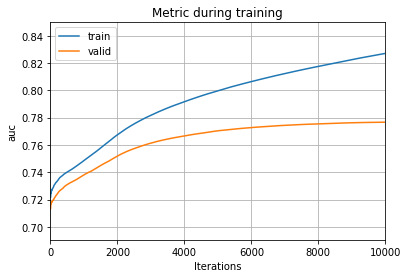

In [28]:
lightgbm.plot_metric(model)

In [ ]:
lightgbm.plot_tree(model)

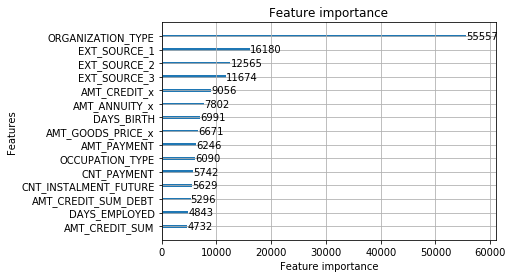

In [33]:
lightgbm.plot_importance(model, max_num_features=15)

In [44]:
model.booster_

### Submission

In [35]:
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
save_prediction(submission, 'lightgbm')

'kaggle competitions submit -c home-credit-default-risk -f /home/inc/work/edu/ndml/capstone/submissions/submission-lightgbm.csv -m "lightgbm"'